# Crop Yield Prediction: Random Forest with Optuna (Part 5)

## Overview
This notebook trains a **Random Forest** model to predict crop yields. You can configure the specific target crop in the data loading section.

## Methodology
1.  **Crop Selection:** Choose the specific crop to predict.
2.  **Feature Analysis:** Review the input variables.
3.  **Time-Series Split:** Divide data by year to ensure we don't predict the past using the future:
    * **Train:** Learn patterns.
    * **Validation:** Tune settings.
    * **Test:** Final evaluation.
4.  **Baseline:** Compare against a simple guess (Last Year's Yield).
5.  **Initial Model:** Train a default model and check learning curves for errors.
6.  **Optimization:** Use **Optuna** to automatically find the best model settings.
7.  **Final Evaluation:** Compare accuracy (RMSE) across all stages.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Preparation and Crop Choice
We load the main dataset and identify the available crops. For this analysis, we focus specifically on **Rice**. We clean the data by removing columns related to other crops and deleting any rows where the target yield information is missing.

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v3.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


### 2. Selecting Features and Splitting Data
We identify the input variables (features), such as weather data and previous years' yields. To prevent the model from "cheating" by seeing the future, we split the data based on time:
* **Training Data:** Years before 2014.
* **Validation Data:** Years 2014 to 2018.
* **Test Data:** Years 2019 and later.

In [3]:
# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
# Example: If predicting Rice, we drop 'avg_yield_lettuce_1y', etc.
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2014 and < 2019) -> This covers 2014 to 2018
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})     : {len(X_train)}")
# Subtract 1 here to show the inclusive range (2014-2018)
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")

Total Features Used: 17
------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude



Training Samples   (<2014)     : 3579
Validation Samples (2014-2018): 575
Testing Samples    (>=2019)    : 575


In [4]:
X_train.head()

,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982,2241.4,2207.10,2181.766667,325.32,154.391016,59.402942,NaN,NaN,NaN,11.699167,-33.899342,-60.110408,NaN,5.778887,34.53,69.17
1,1983,2199.4,2220.40,2204.533333,373.54,186.787027,72.870980,NaN,NaN,NaN,10.650833,-42.640609,-60.922614,NaN,6.672946,34.53,69.17
2,1984,2258.1,2228.75,2232.966667,273.25,211.709895,-21.830163,NaN,NaN,NaN,11.383333,-46.025539,-55.929678,NaN,7.152971,34.53,69.17
3,1985,2241.6,2249.85,2233.033333,196.10,96.438281,33.467341,19.215833,-13.475498,-51.480910,11.888333,-39.599910,-69.677748,NaN,9.178255,34.53,69.17
4,1986,2248.2,2244.90,2249.300000,155.09,67.530475,38.964517,18.741667,-12.861915,-47.249218,12.511667,-31.144849,-60.631870,NaN,9.224020,34.53,69.17


### 3. Setting a Baseline
Before using complex AI, we create a simple baseline to measure success. We assume that the yield this year will be exactly the same as last year. We calculate the error (RMSE) of this simple guess to establish a score we must beat.

In [5]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 533.44


### 4. Initial Model Testing
We train a basic Random Forest model using default settings. We plot a learning curve to ensure the model is learning patterns rather than just memorizing data (overfitting). Since Random Forest (Scikit-Learn) doesn't allow step-by-step evaluation during fitting like LightGBM, we simulate the learning curve by training forests of increasing size.

Training Random Forests for Learning Curve...


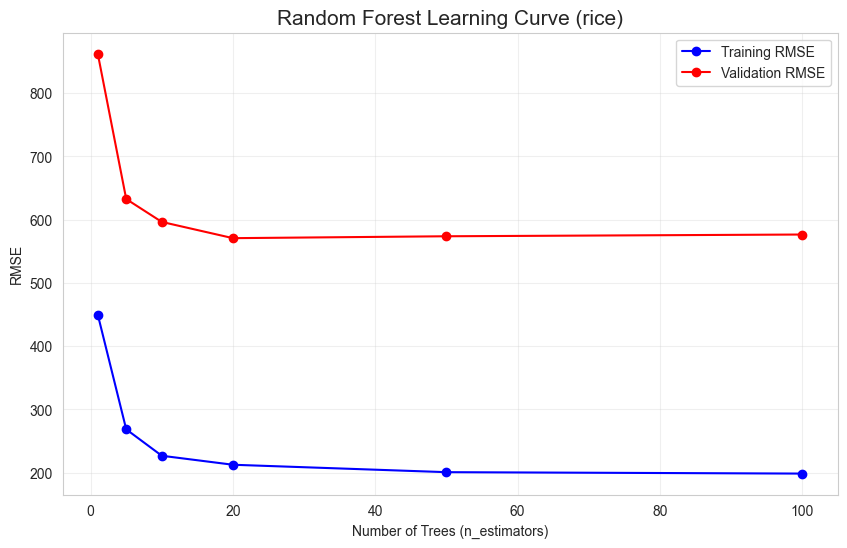

Initial Model Test RMSE: 543.58


In [6]:
# --- PREPROCESSING FOR RANDOM FOREST ---
# Scikit-learn Random Forest does not handle NaNs natively.
# We use SimpleImputer to fill missing values with the mean.
imputer = SimpleImputer(strategy='mean')

# Fit on training data, transform others
X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)
X_test_imp = imputer.transform(X_test)

# --- INITIAL MODEL TRAINING & LEARNING CURVE ---

# To visualize training progress, we train models with increasing n_estimators
n_trees_list = [1, 5, 10, 20, 50, 100]
train_rmse_scores = []
val_rmse_scores = []

print("Training Random Forests for Learning Curve...")
for n in n_trees_list:
    rf = RandomForestRegressor(
        n_estimators=n, 
        max_depth=None,         # unlimited depth initially
        min_samples_split=2,    # default
        min_samples_leaf=1,     # default
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_imp, y_train)
    
    # Evaluate
    train_pred = rf.predict(X_train_imp)
    val_pred = rf.predict(X_val_imp)
    
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_val, val_pred)))

# Define the final initial model (usually 100 trees is default)
model_init = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_init.fit(X_train_imp, y_train)

# --- PLOT LEARNING CURVE (RMSE over Number of Trees) ---
def plot_learning_curve(n_trees_list, train_scores, val_scores):
    plt.figure(figsize=(10, 6))
    
    plt.plot(n_trees_list, train_scores, label='Training RMSE', color='blue', marker='o')
    plt.plot(n_trees_list, val_scores, label='Validation RMSE', color='red', marker='o')
    
    plt.title(f'Random Forest Learning Curve ({CHOSEN_CROP})', fontsize=15)
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(n_trees_list, train_rmse_scores, val_rmse_scores)

# Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test_imp)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"Initial Model Test RMSE: {rmse_init_test:.2f}")

### 5. Tuning the Model (Optuna)
To improve performance, we use **Optuna** to find the best model settings (hyperparameters). We run 50 different trials, adjusting settings like tree depth, split criteria, and number of features, to minimize the error on the validation data.

In [7]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 250, 300),  # narrowed around best 282
    'max_depth': trial.suggest_int('max_depth', 6, 10),            # around 7
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),  # around 3
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 8, 10),   # around 10
    'max_features': trial.suggest_float('max_features', 0.9, 1.0),      # around 0.94
    'random_state': 42,
    'n_jobs': -1
}
    
    # Initialize and Train RF
    model = RandomForestRegressor(**params)
    model.fit(X_train_imp, y_train)
    
    # Predict on Validation
    preds = model.predict(X_val_imp)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_RF'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=50) # Reduced trials for speed in demo, typically 50+

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-05 00:03:38,367] A new study created in memory with name: Rice_Yield_RF
[I 2025-12-05 00:03:39,298] Trial 0 finished with value: 547.7188868560866 and parameters: {'n_estimators': 279, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.9855949106184602}. Best is trial 0 with value: 547.7188868560866.
[I 2025-12-05 00:03:40,135] Trial 1 finished with value: 547.6837372215589 and parameters: {'n_estimators': 256, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.9643485322472758}. Best is trial 1 with value: 547.6837372215589.
[I 2025-12-05 00:03:41,065] Trial 2 finished with value: 546.9588103874177 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.9047150527753972}. Best is trial 2 with value: 546.9588103874177.
[I 2025-12-05 00:03:41,761] Trial 3 finished with value: 547.4195150642263 and parameters: {'n_estimators': 261, 'max_depth': 6, 'min_s


Best Parameters found:
{'n_estimators': 299, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 0.9187401458555887}


### 6. Visualizing Optimization
We generate charts to understand the tuning process. These visual tools show us which specific settings had the biggest impact on reducing the model's error and how the optimization improved over time.

In [8]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_RF_Model"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Final Model Training
Using the best settings found during the tuning phase, we build the final model. We train this model on both the Training and Validation data combined to maximize the information available for learning.

In [9]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Fit Imputer on full training data
imputer_final = SimpleImputer(strategy='mean')
X_train_full_imp = imputer_final.fit_transform(X_train_full)
X_test_final_imp = imputer_final.transform(X_test)

# 2. Initialize with Best Params
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = RandomForestRegressor(**best_params)

# 3. Train on Full History
final_model.fit(X_train_full_imp, y_train_full)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test_final_imp)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

### 8. Results and Analysis
We evaluate the final performance on the Test data (2019–2023).


* **Comparison:** We check if the Tuned Model beats the Baseline and the Initial Model.


--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=533.44, R2=0.9427
Initial Model:  RMSE=543.58, R2=0.9406
Tuned Model:    RMSE=490.35, R2=0.9516 (RMSE Improved 8.08%)


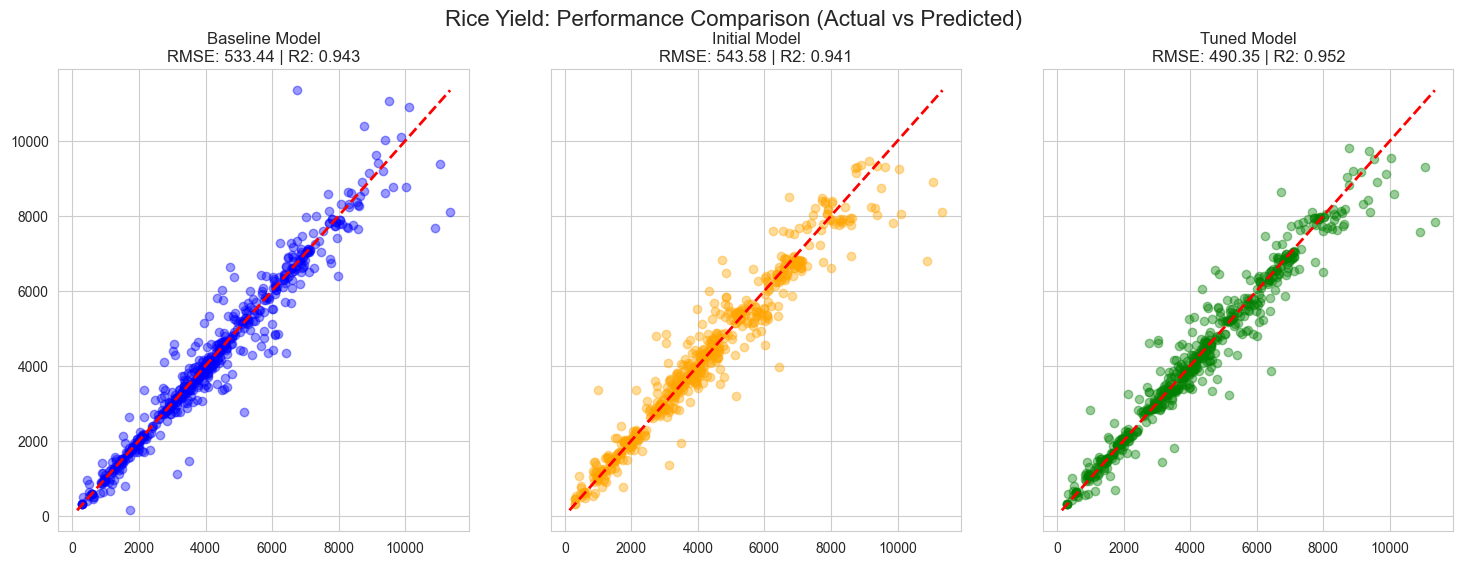

In [10]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.show()

* **Trend Analysis:** We plot the predicted yields against actual yields over time to visualize accuracy.


C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



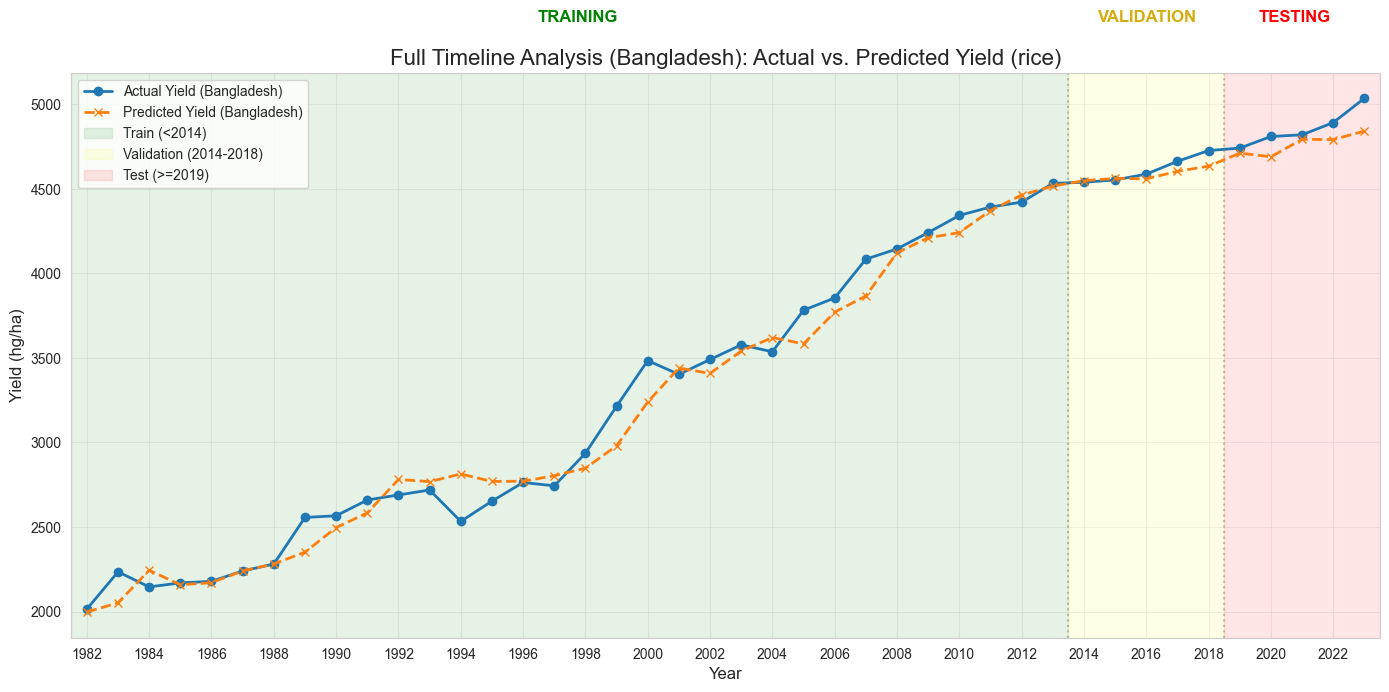

In [11]:
import matplotlib.pyplot as plt

# Ensure these match your previous variables
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# Country parameter
TARGET_COUNTRY = "Bangladesh"

# 1. Generate Predictions
all_predictions = final_model.predict(df_model[feature_cols])

# 2. Create DataFrame WITH AREA column
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Area': df_model['area'],      # added so we can filter by country
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# ❗ 3. Filter for Thailand only
df_th = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]

# Aggregate by Year
yearly_trend = df_th.groupby('Year')[['Actual', 'Predicted']].mean()

# 3. Plotting
plt.figure(figsize=(14, 7))

# Plot Lines
plt.plot(yearly_trend.index, yearly_trend['Actual'], 
         marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2)
plt.plot(yearly_trend.index, yearly_trend['Predicted'], 
         marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2)

# Define Split Boundaries
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()

# CALCULATE OFFSETS
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary   = VAL_END_YEAR - 0.5

# Highlight Periods
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, 
            label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, 
            label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, 
            label=f'Test (>={VAL_END_YEAR})')

# Add Vertical Lines
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# Add Text Labels
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.09 

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', 
         ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', 
         ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', 
         ha='center', fontsize=12, fontweight='bold', color='red')

# Final Formatting
plt.title(f'Full Timeline Analysis ({TARGET_COUNTRY}): Actual vs. Predicted Yield ({CHOSEN_CROP})',
          fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Force x-axis to show integer years
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()


* **Geographic Error:** We map the error rates by country to see where the model performs best and where it struggles.

In [12]:
# --- REFRESHING THE TEST DATA CONTEXT ---
VAL_END_YEAR = 2019
mask_test = df_model['year'] >= VAL_END_YEAR

# We need the original 'area' column from the test set for joining
test_set_context = df_model[mask_test][['area', 'year']] 

# --- RE-CREATE COMPARISON DF WITH FEATURE JOINED ---

# 1. Create the Comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# 2. Join the desired feature column(s)
comparison_df = comparison_df.join(test_set_context)

# 3. Reorder the columns for better readability
comparison_df = comparison_df[['year', 'area', 'Actual_Value', 'Predicted_Value']]

# 4. Display the header
print("--- Actual vs. Predicted Test Set Results with Feature Context ---")
print(comparison_df.head())

--- Actual vs. Predicted Test Set Results with Feature Context ---
    year         area  Actual_Value  Predicted_Value
37  2019  Afghanistan        4476.6      4621.101859
38  2020  Afghanistan        4441.7      4673.998911
39  2021  Afghanistan        4406.5      4627.647007
40  2022  Afghanistan        4625.0      4515.550618
41  2023  Afghanistan        4627.9      4584.709227


In [13]:
import plotly.express as px

# Assuming comparison_df is defined and country names are cleaned up here...
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'United_Kingdom_of_Great_Britain_and_Northern_Ireland': 'United Kingdom',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Bolivia_(Plurinational_State_of)': 'Bolivia',
    'Iran_(Islamic_Republic_of)': 'Iran',
    "Lao_People's_Democratic_Republic": 'Laos',
    'China,_mainland': 'China',
    'China,_Taiwan_Province_of': 'Taiwan',
    "Democratic_People's_Republic_of_Korea": 'North Korea',
    'Republic_of_Korea': 'South Korea',
    'Côte_d\'Ivoire': "Cote d'Ivoire",
    'United_Republic_of_Tanzania': 'Tanzania',
    'Micronesia_(Federated_States_of)': 'Micronesia',
    'Venezuela_(Bolivarian_Republic_of)': 'Venezuela'
})

def plot_geographic_error(comparison_df):
    """
    Aggregates prediction RMSPE and RMSE by country and plots the distribution 
    on a world map using Plotly Express, with both metrics in the hover data.
    """

    # --- 1. Compute Errors ---
    comparison_df['Squared_Error'] = (
        comparison_df['Actual_Value'] - comparison_df['Predicted_Value']
    ) ** 2

    epsilon = 1e-6 
    comparison_df['Squared_Percentage_Error'] = (
        (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / 
        (comparison_df['Actual_Value'] + epsilon)
    ) ** 2

    # --- 2. Aggregate Errors by Country ---
    rmse_df = (
        comparison_df.groupby('area')['Squared_Error']
        .mean()
        .apply(np.sqrt)
        .reset_index()
        .rename(columns={'area': 'Country', 'Squared_Error': 'RMSE'})
    )
    
    rmspe_df = (
        comparison_df.groupby('area')['Squared_Percentage_Error']
        .mean()
        .apply(np.sqrt)
        .multiply(100)
        .reset_index()
        .rename(columns={'area': 'Country', 'Squared_Percentage_Error': 'RMSPE'})
    )

    # 3. Compute mean Actual & Predicted per Country
    ap_df = comparison_df.groupby('area')[['Actual_Value', 'Predicted_Value']].mean().reset_index()
    ap_df = ap_df.rename(columns={'area': 'Country'})

    # 4. Merge RMSPE, RMSE, Actual, and Predicted
    error_stats = rmspe_df.merge(rmse_df, on='Country', how='left') 
    error_stats = error_stats.merge(ap_df, on='Country', how='left') 

    # 5. Choropleth Map
    fig = px.choropleth(
        error_stats,
        locations='Country',
        color='RMSPE',
        locationmode='country names',
        color_continuous_scale=['green', 'red'], 
        range_color=[0, 50], 
        title='Geographic Distribution of Prediction Error (RMSPE)',
        labels={'RMSPE': 'RMSPE (%)'},
        hover_name='Country',
        hover_data={
            'RMSPE': ':.2f',
            'RMSE': ':.2f',
            'Actual_Value': ':.2f',
            'Predicted_Value': ':.2f',
        },
        projection='natural earth'
    )

    # 6. Layout adjustments
    fig.update_layout(
        title_font_size=18,
        coloraxis_colorbar=dict(
            title='RMSPE (%)',
            orientation='h',
            len=0.5,
            yanchor='bottom',
            y=-0.12
        ),
        geo=dict(
            showframe=False,
            showcoastlines=True,
            showcountries=True,
            countrycolor='black',
            bgcolor='lightgrey'
        )
    )

    fig.show()

# Run visualization
plot_geographic_error(comparison_df)

C:\Users\PavinP\AppData\Local\Temp\ipykernel_24936\2231010933.py:67: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 9. Key Factors (Feature Importance)
Finally, we analyze what drives the predictions. We list the top 20 features that influence rice yield. Typically, the most important factors are previous yields (history) and specific climate metrics like temperature and solar radiation.


--- Top 20 Most Important Features (Text Report) ---
              Feature  Importance
0   avg_yield_rice_2y    0.633737
1   avg_yield_rice_1y    0.247524
2   avg_yield_rice_3y    0.105781
3        solar_annual    0.002622
4         temp_annual    0.001403
5         rain_annual    0.001033
6                year    0.000941
7            rain_sin    0.000920
8            temp_sin    0.000861
9     fertilizer_lag1    0.000801
10          solar_cos    0.000738
11          solar_sin    0.000715
12           temp_cos    0.000649
13          longitude    0.000593
14           latitude    0.000587
15           rain_cos    0.000567
16    pesticides_lag1    0.000529


C:\Users\PavinP\AppData\Local\Temp\ipykernel_24936\449948700.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




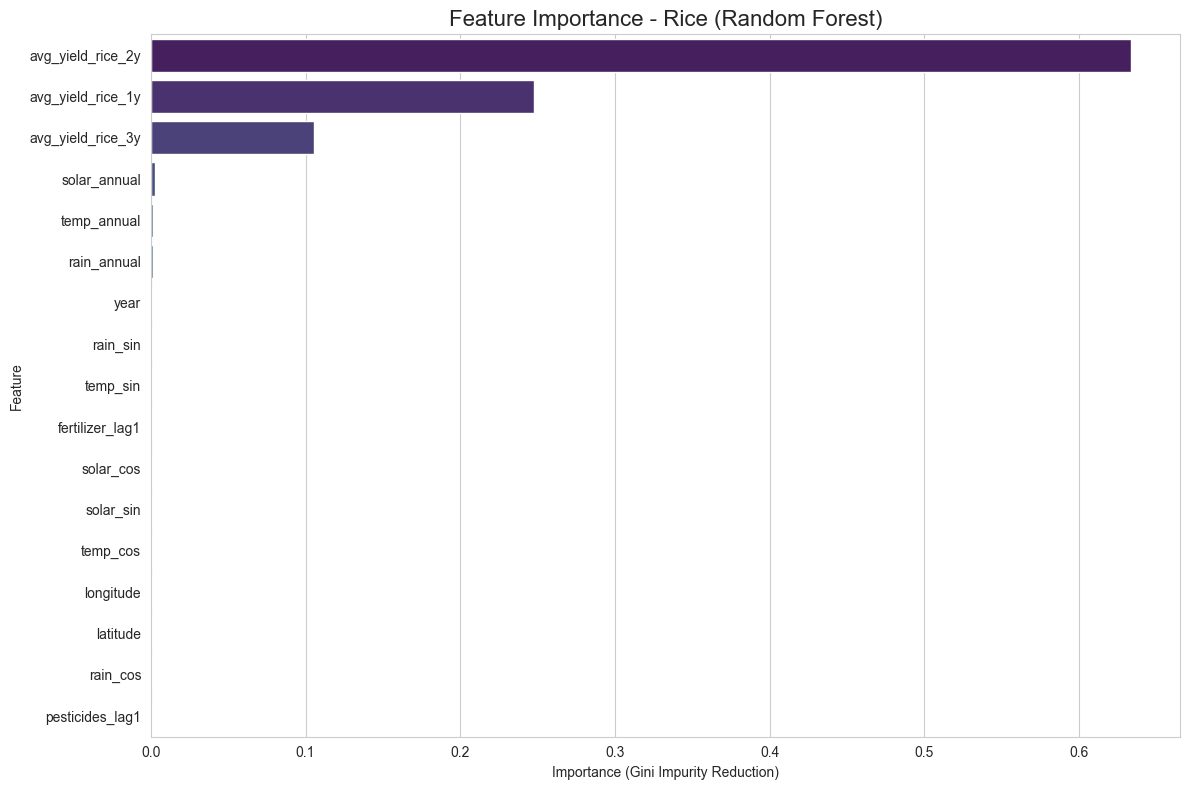

In [14]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances from Random Forest
importances = final_model.feature_importances_
feature_names = feature_cols

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use Seaborn barplot since RF doesn't use lgb.plot_importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title(f'Feature Importance - {CHOSEN_CROP.capitalize()} (Random Forest)', fontsize=16)
plt.xlabel('Importance (Gini Impurity Reduction)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()